In [1088]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random, randint, choice, normal,rand,seed
from scipy.stats import multivariate_normal
from collections import defaultdict
import sys
from tqdm import tqdm

In [1089]:
# First element is cumulative rewards, but is not used for
# environment agents, but provided as 0 for consistency with agents in population. 

Angel     = [0,1.0,1.0,1.0,1.0,1.0] # AN
Devil     = [0,0.0,0.0,0.0,0.0,0.0] # DE
ExplTFT   = [0,1.0,1.0,0.0,0.0,0.0] # EX
Pavlov    = [0,0.5,1.0,0.0,0.0,1.0] # PA
# Random will be created at runtime  #RA
TFT       = [0,1.0,1.0,0.0,1.0,0.0] # TF
Trickster = [0,1.0,0.0,0.0,0.0,0.0] # TR

# To make agents, be sure to make a copy each time, else will share the same list

def make_random_agent():
    return [0,0.5,0.5,0.5,0.5,0.5].copy()

def print_agent(A):    
    A = np.around(A,3)
    print("\nFirst move:",A[1],'\n')    
    print("      C       D")
    print('  -----------------')
    print('  |       |       | ')
    print('C | '+f"{A[2]:{5}}"+ ' | '+f"{A[3]:{5}}"+ ' | ')
    print('  |       |       | ')
    print('  -----------------')
    print('  |       |       | ')
    print('D | '+f"{A[4]:{5}}"+ ' | '+f"{A[5]:{5}}"+ ' | ')
    print('  |       |       | ')
    print('  -----------------')
    print("\nReward:",A[0])
    
def print_population(P):
    for A in P:
        print(list(np.around(A,3)))
    print()
    
# Environment is collection chosen from the above list

# makeup is list of how many of each, in order:
#           [ AN, DE, EX, PA, RA, TF, TR ]


def make_environment(makeup):
    (AN,DE,EX,PA,RA,TF,TR) = makeup
    Env =   [Angel]     * AN \
          + [Devil]     * DE \
          + [ExplTFT]   * EX \
          + [Pavlov]    * PA \
          + [ make_random_agent() for k in range(RA)]\
          + [TFT]       * TF \
          + [Trickster] * TR


    return Env

# create standard environments -- all have 10 agents. Could change this by changing the multiplier

m = 1      # multiplier

#                                      AN  DE  EX  PA  RA  TF  TR
All_Angels_Env     = make_environment( [10*m,  0,  0,  0,  0,  0,  0 ] )
All_Devils_Env     = make_environment( [ 0, 10*m,  0,  0,  0,  0,  0 ] )
All_ExplTFTs_Env   = make_environment( [ 0,  0, 10*m,  0,  0,  0,  0 ] )
All_Pavlovs_Env    = make_environment( [ 0,  0,  0, 10*m,  0,  0,  0 ] )
Random_Env         = make_environment( [ 0,  0,  0,  0, 10*m,  0,  0 ] )
All_TFTs_Env       = make_environment( [ 0,  0,  0,  0,  0, 10*m,  0 ] )
All_Tricksters_Env = make_environment( [ 0,  0,  0,  0,  0,  0, 10*m ] )
Mixed_Env          = make_environment( [ 2*m,  1*m,  1*m,  1*m,  1*m,  3*m,  1*m ] )

Environments = [All_Angels_Env,All_Devils_Env,All_ExplTFTs_Env,\
                All_Pavlovs_Env,Random_Env,All_TFTs_Env,All_Tricksters_Env,Mixed_Env]

Environments_labels = ['All_Angels_Env','All_Devils_Env','All_ExplTFTs_Env',\
                'All_Pavlovs_Env','Random_Env','All_TFTs_Env','All_Tricksters_Env','Mixed_Env']

print('Mixed_Env:')
print_population(Mixed_Env)

print("\nPavlov:", Pavlov)
print_agent(Pavlov)

print("\nTFT:", TFT)
print_agent(TFT)

Mixed_Env:
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 1.0, 1.0, 0.0, 0.0, 0.0]
[0.0, 0.5, 1.0, 0.0, 0.0, 1.0]
[0.0, 0.5, 0.5, 0.5, 0.5, 0.5]
[0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[0.0, 1.0, 1.0, 0.0, 1.0, 0.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


Pavlov: [0, 0.5, 1.0, 0.0, 0.0, 1.0]

First move: 0.5 

      C       D
  -----------------
  |       |       | 
C |   1.0 |   0.0 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.0 |   1.0 | 
  |       |       | 
  -----------------

Reward: 0.0

TFT: [0, 1.0, 1.0, 0.0, 1.0, 0.0]

First move: 1.0 

      C       D
  -----------------
  |       |       | 
C |   1.0 |   0.0 | 
  |       |       | 
  -----------------
  |       |       | 
D |   1.0 |   0.0 | 
  |       |       | 
  -----------------

Reward: 0.0


In [1090]:
# Reproduction

# force probability to be in range [0..1]

def rectify(x):
    if x>1:
        return 1
    elif x<0:
        return 0
    else:
        return x
    
# change randomly selected probability by normally-distributed offset 
# Must rectify to make sure is in range 0..1

def mutate(A, mutate_std):
    B = A.copy() 
    
    index_to_mutate = randint(1, 6)
    B[index_to_mutate] += normal(0, scale=mutate_std)
    B[index_to_mutate] = rectify(B[index_to_mutate])

    return B

# crossover each probability of the strategies A and B by creating new agent C,
# and for each index 1..5, copy over from A with probability crossover_p and keep value
# from B with probability 1 - crossover_p.
def crossover(A, B, crossover_p):
    C = B.copy()
    
    for i in range(1, 6):
        if random() < crossover_p:
            C[i] = A[i]

    return C

# crossover and then mutate to create child, which is returned
def make_child(A, B, crossover_p=0.5, mutate_std=0.2):
    C = crossover(A, B, crossover_p)
    C = mutate(C, mutate_std)
    return C

# test

seed(0)

print( mutate([0, 0,1.0,0.5,0.5,0.5], 0.1) )
print( crossover([0,1,1,1,1,1],[0,0,0,0,0,0],0.5) )
print( make_child([0,0.5,0.5,0.5,0.5,0.5],[0,0,0,0,0,0],0.5,0.2 ) )

[0, 0, 1.0, 0.5, 0.5, 0.6122794918829129]
[0, 0, 0, 0, 1, 1]
[0, 0.5, 0.5605610439106163, 0.5, 0, 0.5]


In [1091]:
# Set up Environment and Population

# Payoffs

payoffs = { ('C','C'):300, ('C','D'):-100, ('D','C'):500, ('D','D'):-10 }

# look up what index should be consulted for the first round, or for what happened
# last time after the first round. 

MoveIndex = { ('First','First'):1, ('C','C'):2, ('C','D'):3,\
                                     ('D','C'):4, ('D','D'):5    }

# play IPD between A and B and return reward for each of A and B at end of num_rounds rounds

def play_game(A, B, num_rounds):
    reward_A = reward_B = 0
    
    last_move_A = last_move_B = 'First'

    for _ in range(num_rounds):
        move_A = choice(['C', 'D'], p=[A[MoveIndex[(last_move_A, last_move_B)]], 1 - A[MoveIndex[(last_move_A, last_move_B)]]])
        move_B = choice(['C', 'D'], p=[B[MoveIndex[(last_move_B, last_move_A)]], 1 - B[MoveIndex[(last_move_B, last_move_A)]]])
        
        reward_A += payoffs[(move_A, move_B)]
        reward_B += payoffs[(move_B, move_A)]

        last_move_A = move_A
        last_move_B = move_B

    return (reward_A, reward_B)

# test

A = Angel
B = Devil
print(A)
print(B)
(ra,rb) = play_game(A,B,10)
print(ra,rb)
print()

# play IPD with every member of Env and return cumulative reward
def get_reward(A, Env, num_rounds):
    total_reward = 0
    
    for B in Env:
        reward_A, _ = play_game(A, B, num_rounds)
        total_reward += reward_A

    return total_reward


# test

print(get_reward(Angel,All_Devils_Env,10))
print(get_reward(TFT,All_Angels_Env,10))

[0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0, 0.0, 0.0, 0.0, 0.0, 0.0]
-1000 5000

-10000
30000


In [1092]:
# Keep track of winner in each round

def record_parameters(A,Params):
    for k in range(len(Params)):
        Params[k].append(A[k])

# Display subplots of rewards and the strategy which evolved

def display_evolution(Params):
    print()
    titles = ['Payoff','First','CC','CD','DC','DD']
    fig = plt.figure(figsize=(12,10))
    ax1 = plt.subplot(211)
    fig.subplots_adjust(hspace=0.4)
    plt.title("Rewards")
    plt.grid(color='r',alpha=0.1)    
    plt.ylabel("Reward")
    plt.xlabel("Generations")
    plt.plot(Params[0])
 
    ax2 = plt.subplot(212, sharex=ax1)
    plt.title("Strategy as Probability of Cooperate")
    plt.grid(color='r',alpha=0.1)  
    plt.ylabel("Probability of C")
    plt.xlabel("Generations")
    plt.ylim(-0.1,1.1)
    for k in range(1,6):         
        plt.plot(Params[k],label=titles[k])
    plt.legend()
    plt.show()
    print()

    print("Best agent in last generation:")
    print_agent( [ Params[i][-1] for i in range(len(Params)) ] )    

Environment: All_Angels_Env
[100000.0, 0.0, 0.082, 0.432, 0.0, 0.408]
[100000.0, 0.0, 0.195, 0.432, 0.0, 0.414]
[100000.0, 0.0, 0.071, 0.432, 0.0, 0.259]
[100000.0, 0.0, 0.0, 0.432, 0.0, 0.259]
[100000.0, 0.0, 0.053, 0.432, 0.0, 0.408]
[100000.0, 0.0, 0.0, 0.302, 0.0, 0.259]
[100000.0, 0.0, 0.071, 0.453, 0.0, 0.259]
[100000.0, 0.0, 0.082, 0.432, 0.0, 0.541]
[100000.0, 0.0, 0.053, 0.432, 0.0, 0.259]
[100000.0, 0.154, 0.082, 0.432, 0.0, 0.408]




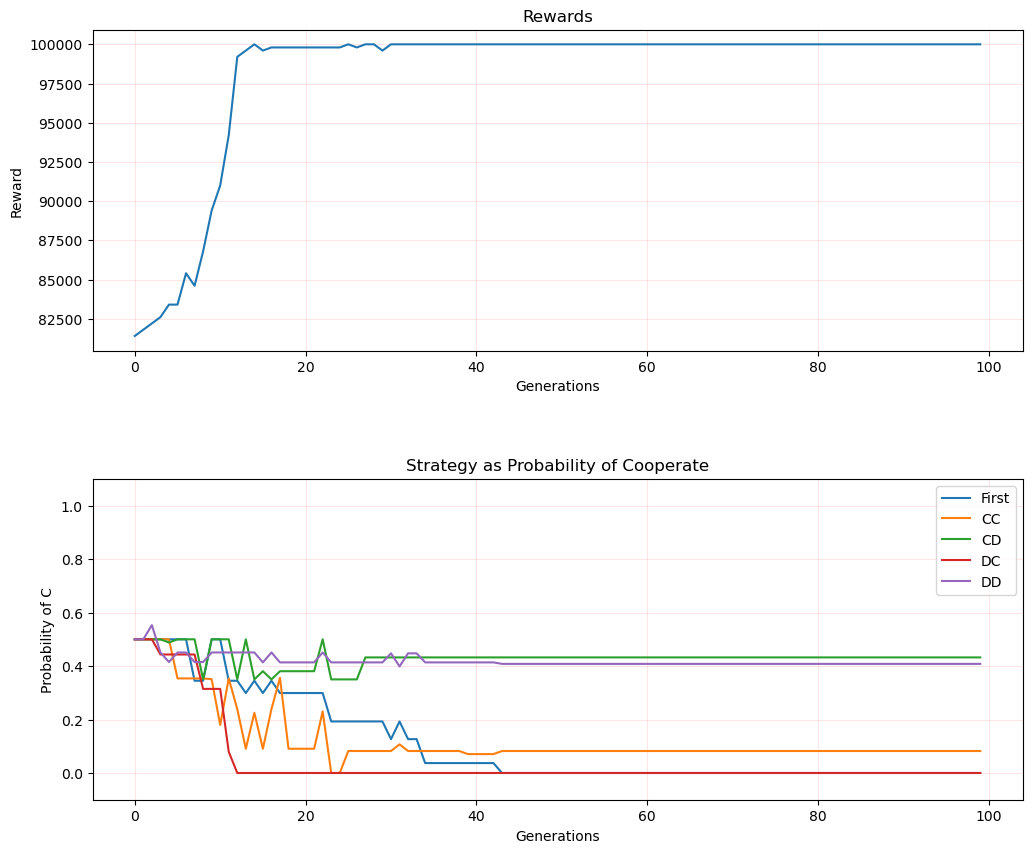


Best agent in last generation:

First move: 0.0 

      C       D
  -----------------
  |       |       | 
C | 0.082 | 0.432 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.0 | 0.408 | 
  |       |       | 
  -----------------

Reward: 100000.0


In [1093]:
# Run an experiment

def run_experiment(environment,population_size,num_children,
                   num_generations,crossover_prob=0.5, mutate_std=0.1,
                   num_rounds=100, play_each_other=False, 
                   print_pop=False, display_evol=True):

    # make the population of random agents, which start with P(C) = 0.5 for all actions
    population = [make_random_agent() for _ in range(population_size)]

    # keep track of parameters for best agent in each generation

    #             Reward First  CC  CD  DC  DD
    parameters = [    [],   [], [], [], [], [] ]

    for k in range(num_generations):     

        # play each agent against the environment and insert the reward into A[0]
        # if play_each_other is True, then play against environment + population, 
        # else just play against evironment
        for A in population:
            A[0] = 0
            if play_each_other:
                A[0] = get_reward(A, environment + population, num_rounds)
            else:
                A[0] = get_reward(A, environment, num_rounds)


        # sort the population in descending order of rewards from this generation
        population.sort(reverse=True, key=(lambda x: x[0])) 

        # record best agent
        record_parameters(population[0],parameters)

        # generate children: delete the last num_children agents in population (those
        # with the worst rewards in this generation), use the remaining population
        # as parents to create num_children new children to add to the population. 
        # Select parents randomly from the remaining population. 
        for _ in range(num_children):
            # Remove the worst agents
#             print("len", len(population))
            population.pop()
        
        new_children = []
        for _ in range(num_children):
            # Create a child and add it to the population
            ind = choice(range(len(population)), size=2, replace=False) # choose 2 indices
            parents = [population[ind[0]], population[ind[1]]]
            child = make_child(parents[0], parents[1], crossover_p=crossover_prob, mutate_std=mutate_std)
            new_children.append(child)
            
        population += new_children

        
    # Display evolution of best agents
    if print_pop:
        print_population(population)
    if display_evol:    
        display_evolution(parameters)

# test
seed(0)
print("Environment: All_Angels_Env")
run_experiment(environment=Environments[0],
               population_size=10,
               num_children=5,
               num_generations=100,
               crossover_prob=0.5, 
               mutate_std=0.1,
               num_rounds=20,
               play_each_other=False,
               print_pop=True,
               display_evol=True)


# All Angels

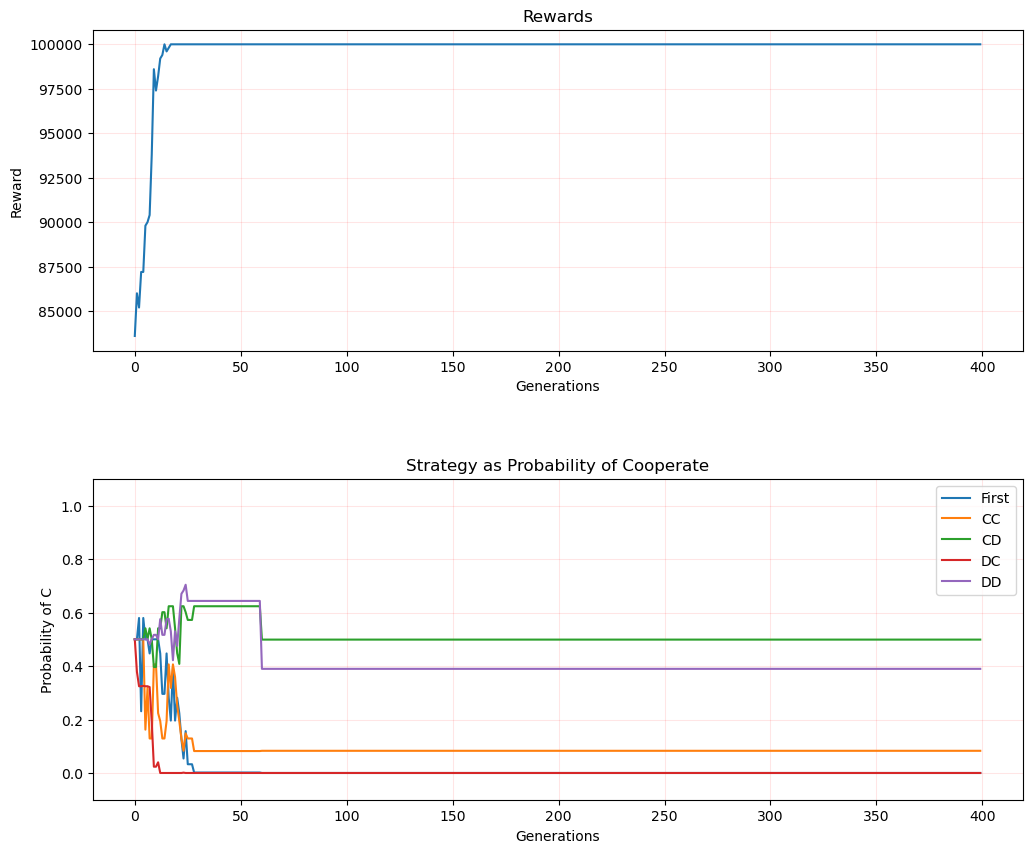


Best agent in last generation:

First move: 0.0 

      C       D
  -----------------
  |       |       | 
C | 0.083 | 0.499 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.0 |  0.39 | 
  |       |       | 
  -----------------

Reward: 100000.0


In [1094]:
run_experiment(environment=Environments[0],
               population_size=100,          
               num_children=50,              
               num_generations=400,          
               crossover_prob=0.5,           
               mutate_std=0.1,               
               num_rounds=20,                
               play_each_other=False,
               print_pop=False,
               display_evol=True)

As expected, the population quickly learns to never cooperate. The first move is to defect for obvious reasons. If the opponent cooperates, which it always will, our agent will begin defecting forever. The right column is insignificant because angels never defect, so we don't need to think too much about it.

The top left box, denoting the probability of cooperating if the previous round was CC, is also relatively meaningless, since no round will be CC for this agent. It may have evolved basically accidentally, and the low value indicates that it wasn't ever prioritized by prior populations.

In this pairing, this is basically the devil strategy. Against other opponents, where other actions will be taken, this will not be the devil strategy.

# All Devils

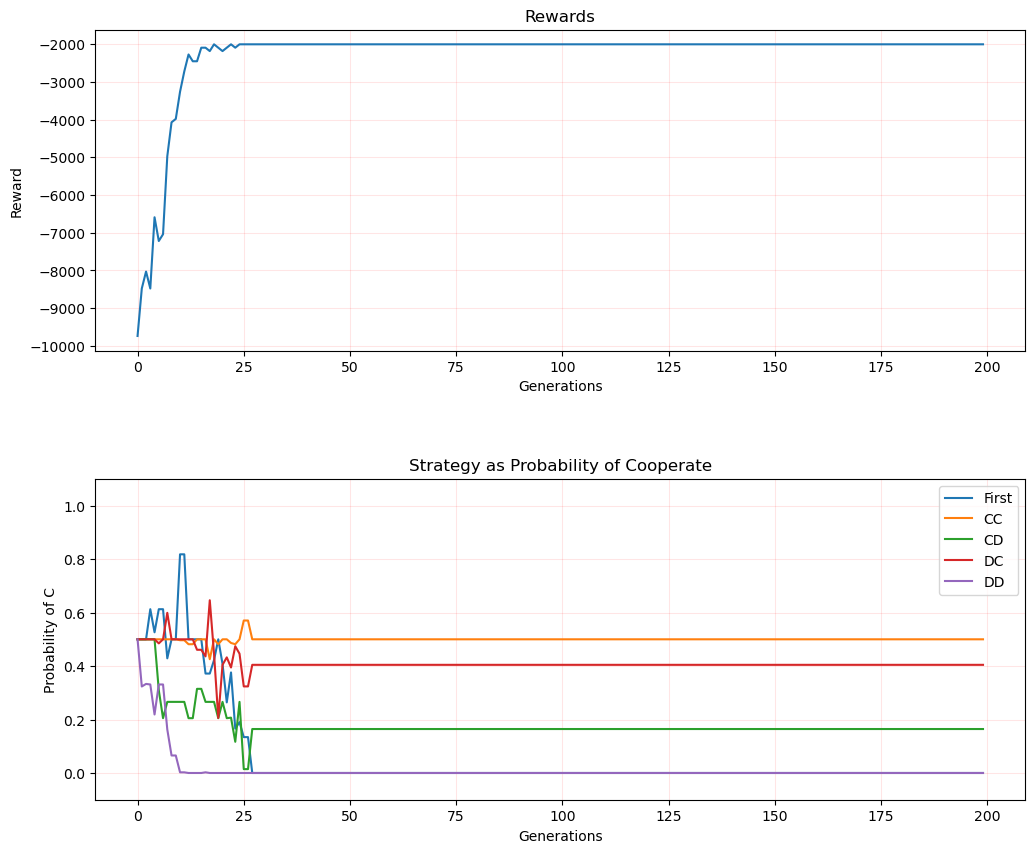


Best agent in last generation:

First move: 0.0 

      C       D
  -----------------
  |       |       | 
C |   0.5 | 0.164 | 
  |       |       | 
  -----------------
  |       |       | 
D | 0.405 |   0.0 | 
  |       |       | 
  -----------------

Reward: -2000.0


In [1095]:
run_experiment(environment=Environments[1] ,
               population_size=100,          
               num_children=50,             
               num_generations=200,          
               crossover_prob=0.5,           
               mutate_std=0.1,               
               num_rounds=20,                
               play_each_other=False,
               print_pop=False,
               display_evol=True)

This time the population evolves to always defect, mimicking the Devil strategy. This minimizes the losses since the opponent is always defecting. This time the first column becomes irrelevant, not really optimized for anything since the environment didn't put that pressure on the population. CD seems like it was on its way out because it's not rewarding to ever cooperate, but it got stuck at 0.164 when DD=0.0 evolved.

# All ExplTFTs

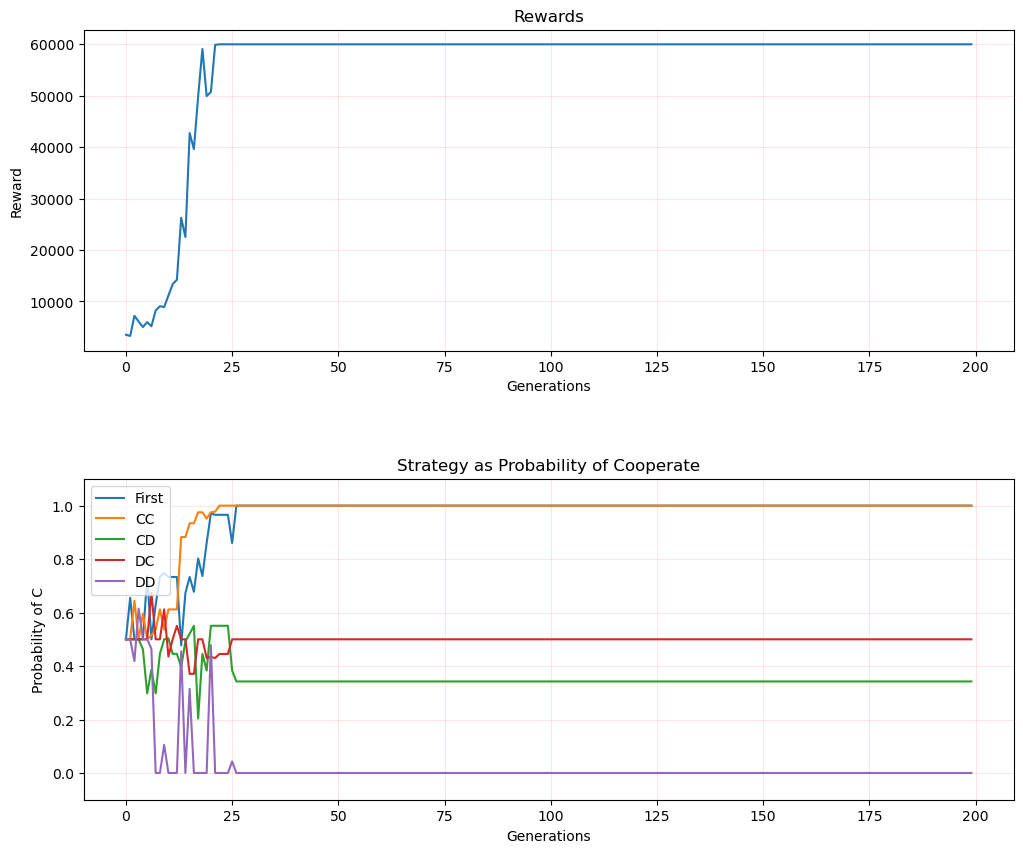


Best agent in last generation:

First move: 1.0 

      C       D
  -----------------
  |       |       | 
C |   1.0 | 0.342 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.5 |   0.0 | 
  |       |       | 
  -----------------

Reward: 60000.0


In [1097]:
run_experiment(environment=Environments[2] ,
               population_size=100,          
               num_children=50,              
               num_generations=200,          
               crossover_prob=0.5,           
               mutate_std=0.1,               
               num_rounds=20,                
               play_each_other=False,
               print_pop=False,
               display_evol=True)

Exploitative TFT always cooperates on the first move, so the population adapts by also cooperating on the first move to maximize rewards. Additionally, ExplTFT will only defect if we defect, so the population learns to never defect. The other boxes get stuck in whatever state they were in when CC=1.0 evolved.

# All Pavlov

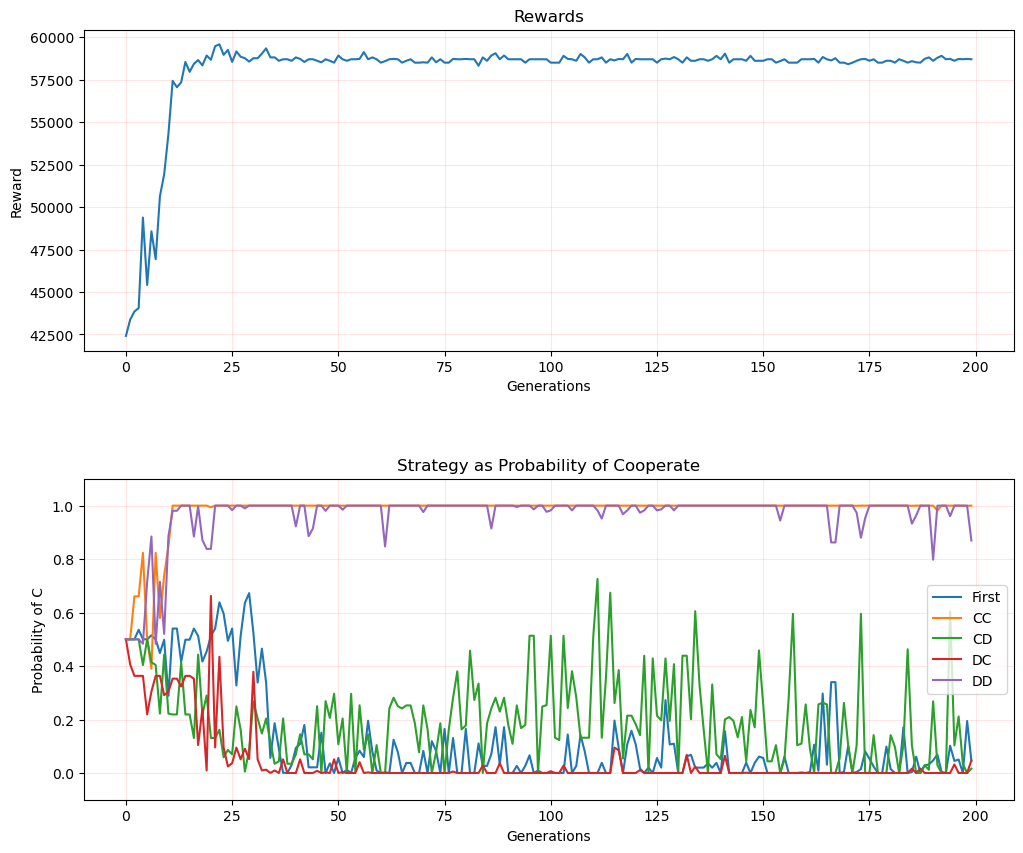


Best agent in last generation:

First move: 0.045 

      C       D
  -----------------
  |       |       | 
C |   1.0 | 0.016 | 
  |       |       | 
  -----------------
  |       |       | 
D | 0.047 | 0.869 | 
  |       |       | 
  -----------------

Reward: 58700.0


In [1098]:
run_experiment(environment=Environments[3] ,
               population_size=100,          
               num_children=50,              
               num_generations=200,          
               crossover_prob=0.5,           
               mutate_std=0.1,               
               num_rounds=20,                
               play_each_other=False,
               print_pop=False,

               display_evol=True)

The population pretty much evolved a Pavlov strategy with small probabilities of making a "mistake." This is expected, as Pavlov generally does well with itself.

First move: good to defect because Pavlov is going to sometimes cooperate and sometimes defect, so defecting is optimal most of the time. This the greedy-optimal strategy for a single round if we don't know what the opponent is going to do initially, and it seems it remained optimal for the population.

DD being close to 1 lets both players return to CC to get us more rewards. The reason why it's slightly less than 1 is probably because defecting when Pavlov is going to cooperate will cause Pavlov to defect in the following round where we also defect (DC=close to 0), after which we are going to defect with a 0.869 probability, which gets us back to CC. This is marginally better than DD=1.0 because it gives us some extra points for sometimes tricking Pavlov in a controlled way. I.e. DD -> sometimes DC -> DD -> mostly CC (which is very good for us). Smart.

# Random Environment

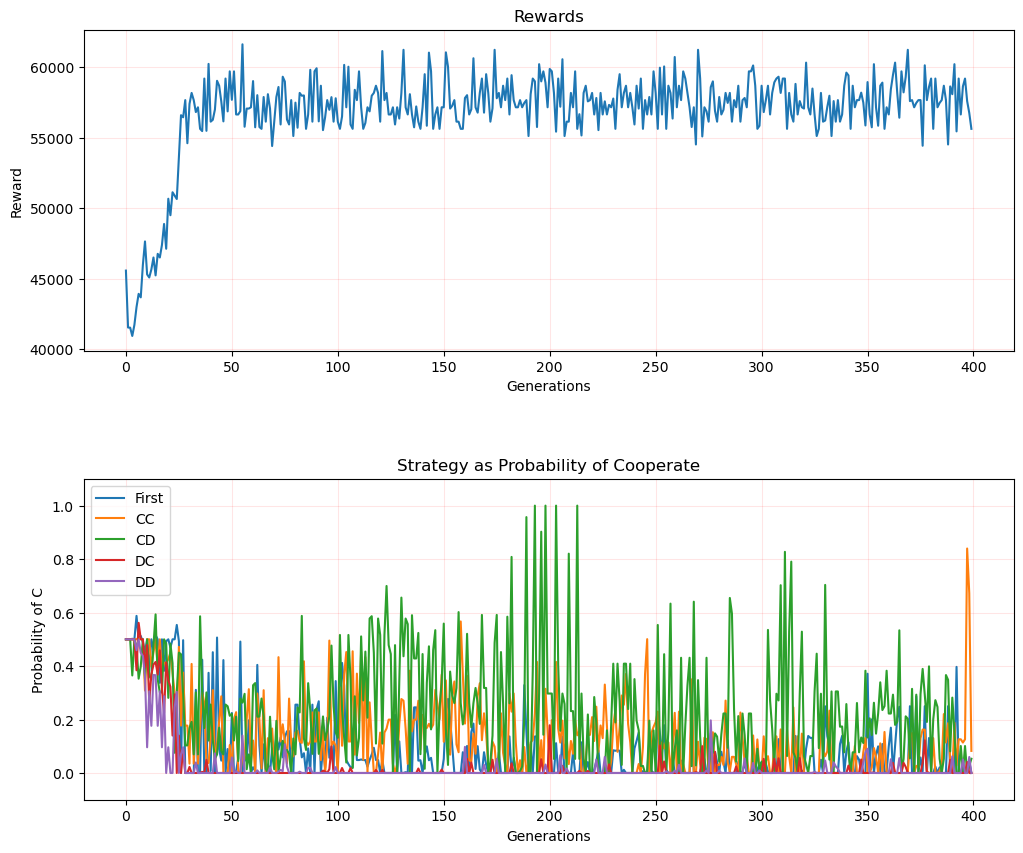


Best agent in last generation:

First move: 0.0 

      C       D
  -----------------
  |       |       | 
C | 0.083 | 0.053 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.0 |   0.0 | 
  |       |       | 
  -----------------

Reward: 55630.0


In [1099]:
run_experiment(environment=Environments[4] ,
               population_size=100,          
               num_children=50,              
               num_generations=400,          
               crossover_prob=0.5,           
               mutate_std=0.1,               
               num_rounds=20,                
               play_each_other=False,
               print_pop=False,
               display_evol=True)

As expected, always defecting is a safe bet if you don't know your opponent. I don't know what to make of the extreme variability of CD.

# All TFTs

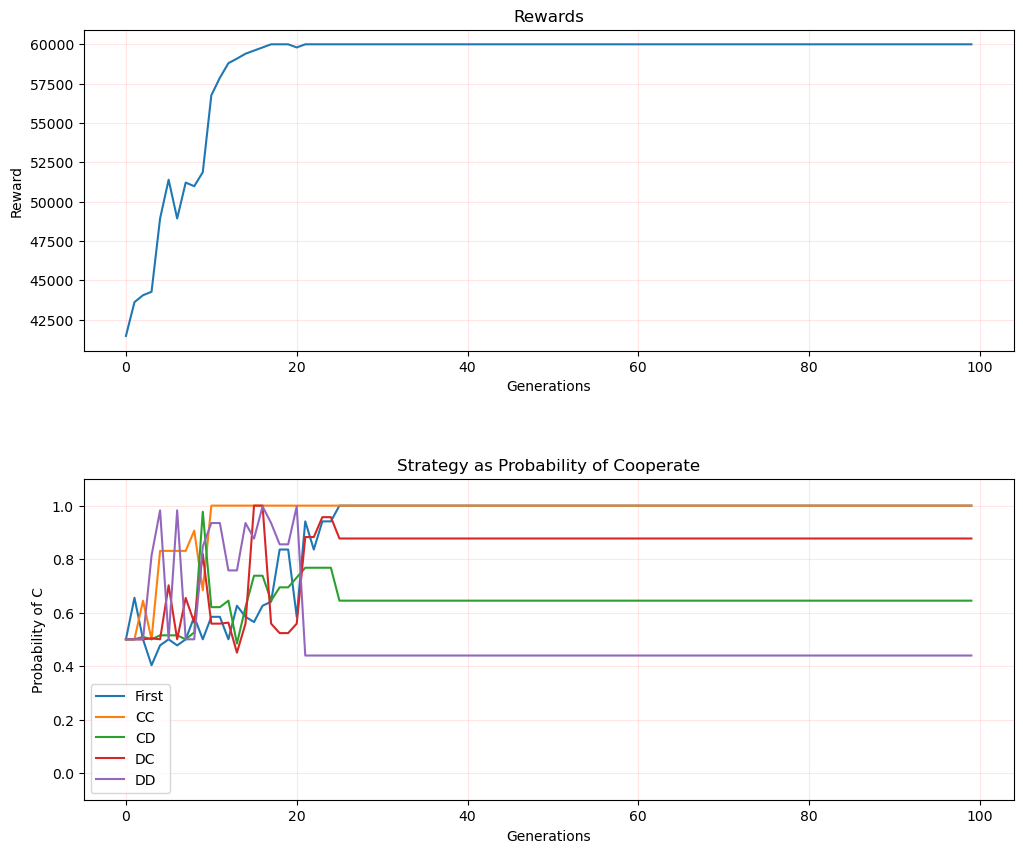


Best agent in last generation:

First move: 1.0 

      C       D
  -----------------
  |       |       | 
C |   1.0 | 0.645 | 
  |       |       | 
  -----------------
  |       |       | 
D | 0.877 | 0.439 | 
  |       |       | 
  -----------------

Reward: 60000.0


In [13]:
run_experiment(environment=Environments[5] ,
               population_size=100,    
               num_children=50,        
               num_generations=100,    
               crossover_prob=0.5,     
               mutate_std=0.1,         
               num_rounds=20,          
               play_each_other=False,
               print_pop=False,
               display_evol=True)

Population learns to always cooperate, since TFT will start with cooperating and then repeat our moves. Everything else is stuck in some local optimum.

An interesting thing here is that other pairings continue to vary in probability up until first move evolves to be 1.0. That means that, whatever was going on there, the population was probably evolving to get out of long defect cycles ASAP to get back to CC, which already had a 1.0 probability long before first-move got there.

DC was rising until it lost its relevance, but managed to become fairly common. If we defected and the opponent cooperated, if we really know that the opponent is TFT, we know that they are going to defect on the next move. So the best move short-term is to defect. But since we're playing multiple rounds, it's worth it to take a single hit by cooperating, so that we can get back to cooperating forever after. This is how the population was adapting to its suboptimal tendency to sometimes defect on the first move.

# All Tricksters

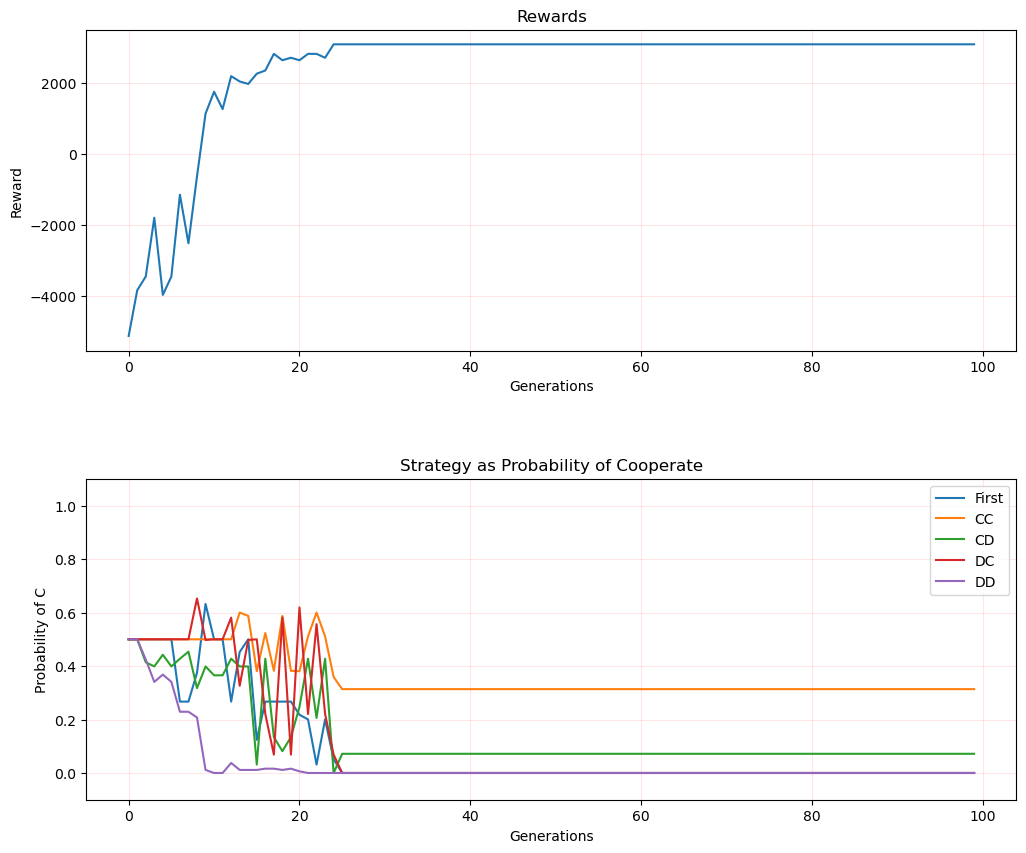


Best agent in last generation:

First move: 0.0 

      C       D
  -----------------
  |       |       | 
C | 0.314 | 0.072 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.0 |   0.0 | 
  |       |       | 
  -----------------

Reward: 3100.0


In [14]:
run_experiment(environment=Environments[6] ,
               population_size=100,          
               num_children=50,              
               num_generations=100,          
               crossover_prob=0.5,           
               mutate_std=0.1,               
               num_rounds=20,                
               play_each_other=False,
               print_pop=False,
               display_evol=True)

Trick the trickster by defecting on the first move (they will cooperate), always defect thereafter because they will also defect. In this environment this is the same as a Devil strategy. CC and CD are inconclusive because they became irrelevant when the Devils strat evolved.

# Mixed environment

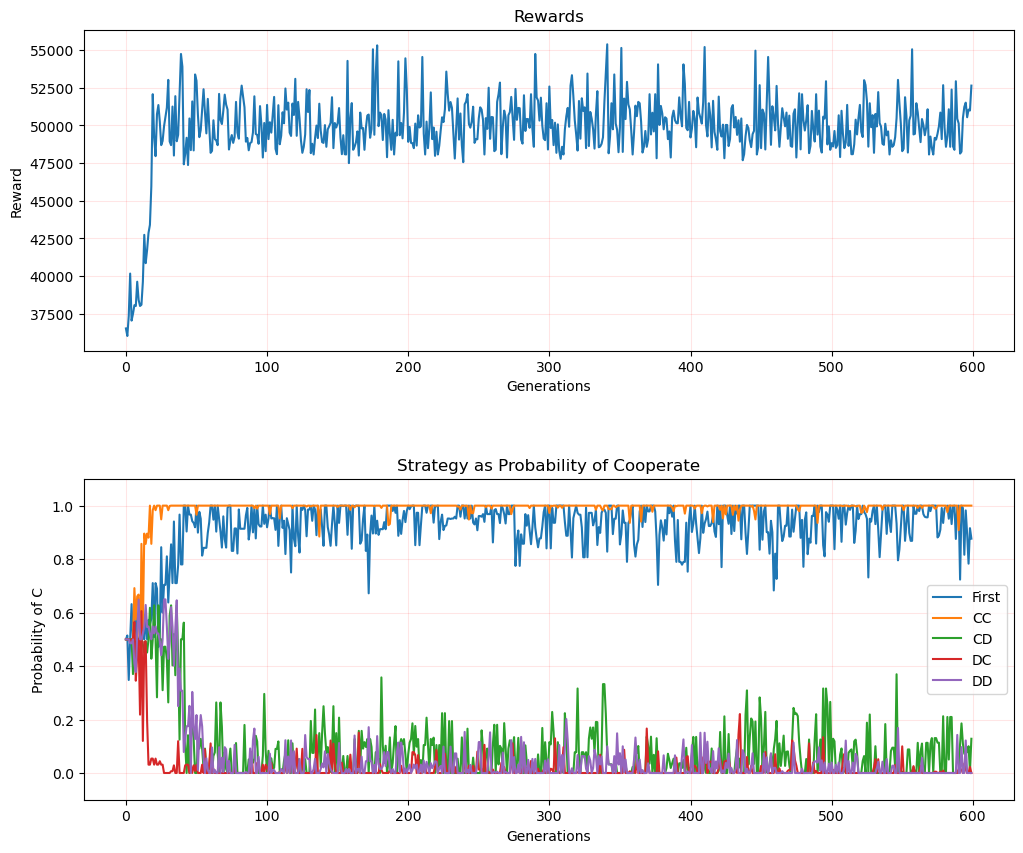


Best agent in last generation:

First move: 0.877 

      C       D
  -----------------
  |       |       | 
C |   1.0 | 0.128 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.0 |   0.0 | 
  |       |       | 
  -----------------

Reward: 52640.0


In [1102]:
run_experiment(environment=Environments[7] ,
               population_size=100,          
               num_children=50,              
               num_generations=600,          
               crossover_prob=0.5,           
               mutate_std=0.1,               
               num_rounds=20,                
               play_each_other=False
               print_pop=False,
               display_evol=True)

4/6 opponents have P(CC)=1.0, so it's best to also evolve CC=1.0 to reap the benefits of this lovely company. Other probabilities were gravitating towards 0.0s, so I guess CC=1.0 was the main strategy.

## play_each_other=True

# All Devils

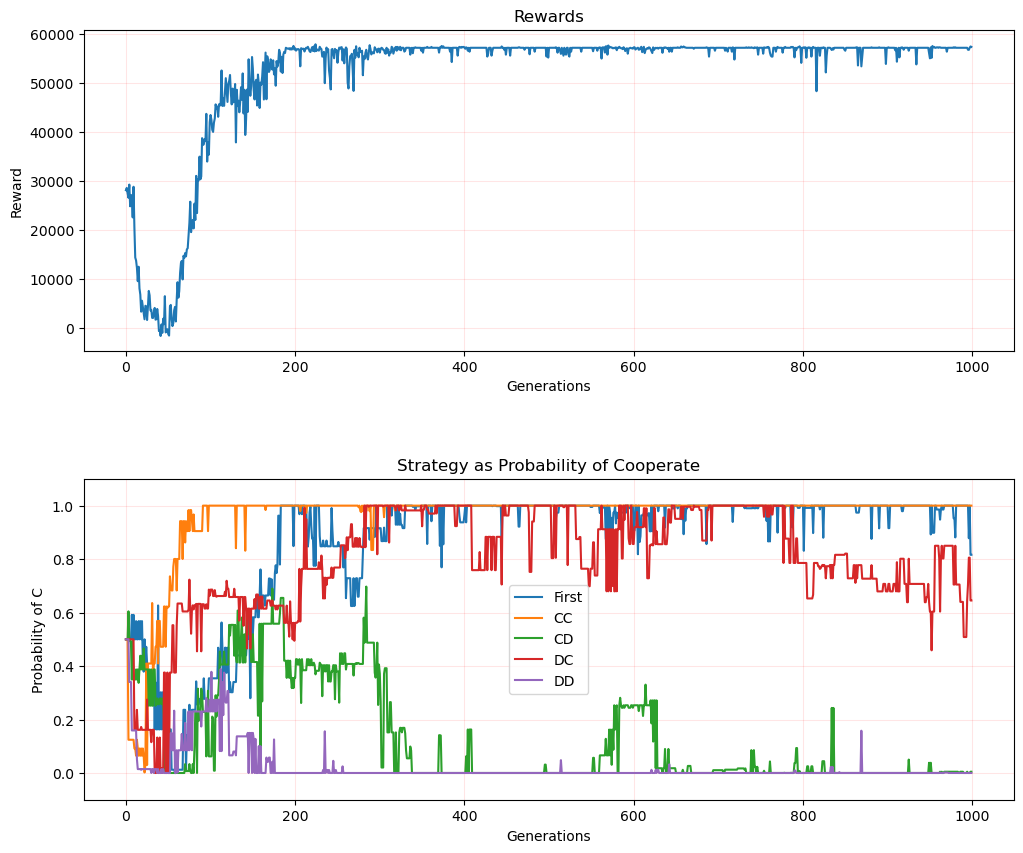


Best agent in last generation:

First move: 0.816 

      C       D
  -----------------
  |       |       | 
C |   1.0 | 0.005 | 
  |       |       | 
  -----------------
  |       |       | 
D | 0.645 |   0.0 | 
  |       |       | 
  -----------------

Reward: 57280.0


In [1103]:
run_experiment(environment=Environments[1] ,
               population_size=10,          
               num_children=5,              
               num_generations=1000,        
               crossover_prob=0.5,          
               mutate_std=0.1,              
               num_rounds=20,               
               play_each_other=True,
               print_pop=False,
               display_evol=True)

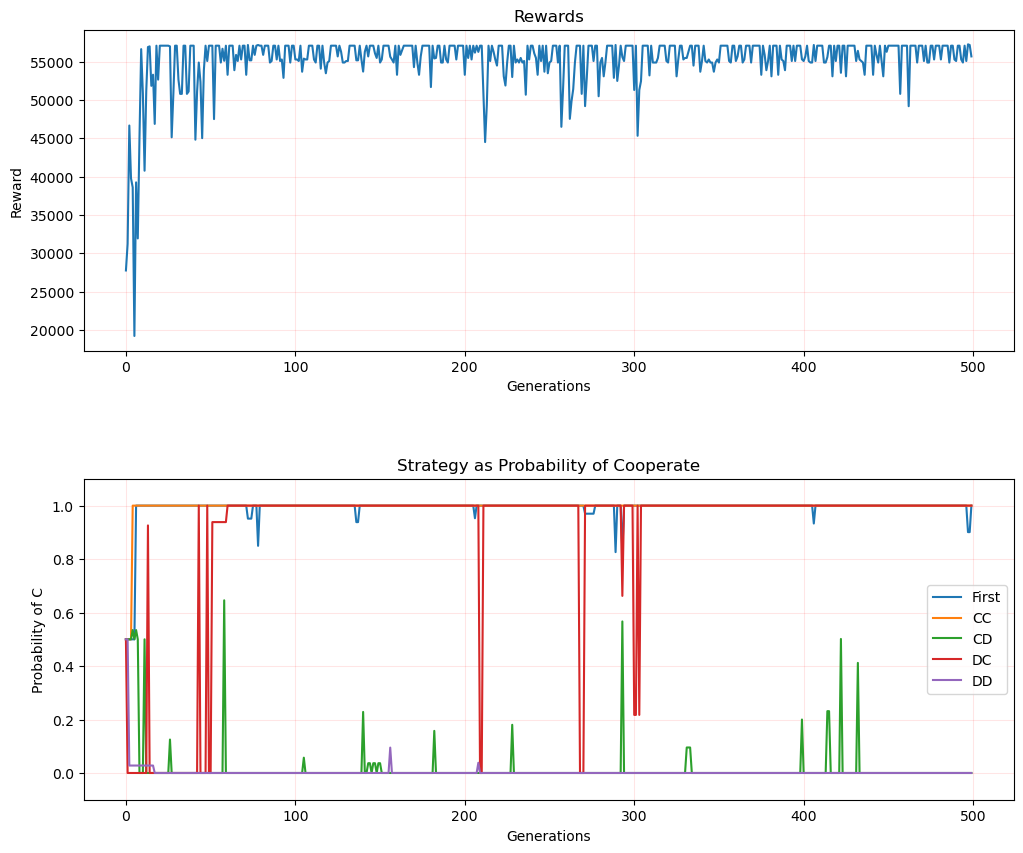


Best agent in last generation:

First move: 1 

      C       D
  -----------------
  |       |       | 
C |     1 |     0 | 
  |       |       | 
  -----------------
  |       |       | 
D |     1 |     0 | 
  |       |       | 
  -----------------

Reward: 55700


In [1110]:
run_experiment(environment=Environments[1] ,
               population_size=10,          
               num_children=5,              
               num_generations=500,         
               crossover_prob=0.9,          
               mutate_std=0.9,              
               num_rounds=20,               
               play_each_other=True,
               print_pop=False,
               display_evol=True)

In these problems the populations are also competing amongst themselves, so the population gradually evolves to prioritize cooperating within itself rather than just minimizing losses from the Devils. At the start, we can see that all probabilities of cooperating drop rapidly to do well against a Devil population, but 1-2 cooperating agents evolving will already make the environment ripe for more cooperating parties. It's more rewarding to be an Angel to actually win some rewards, so the whole population ultimately evolves just to cooperate with itself.

# All Pavlov

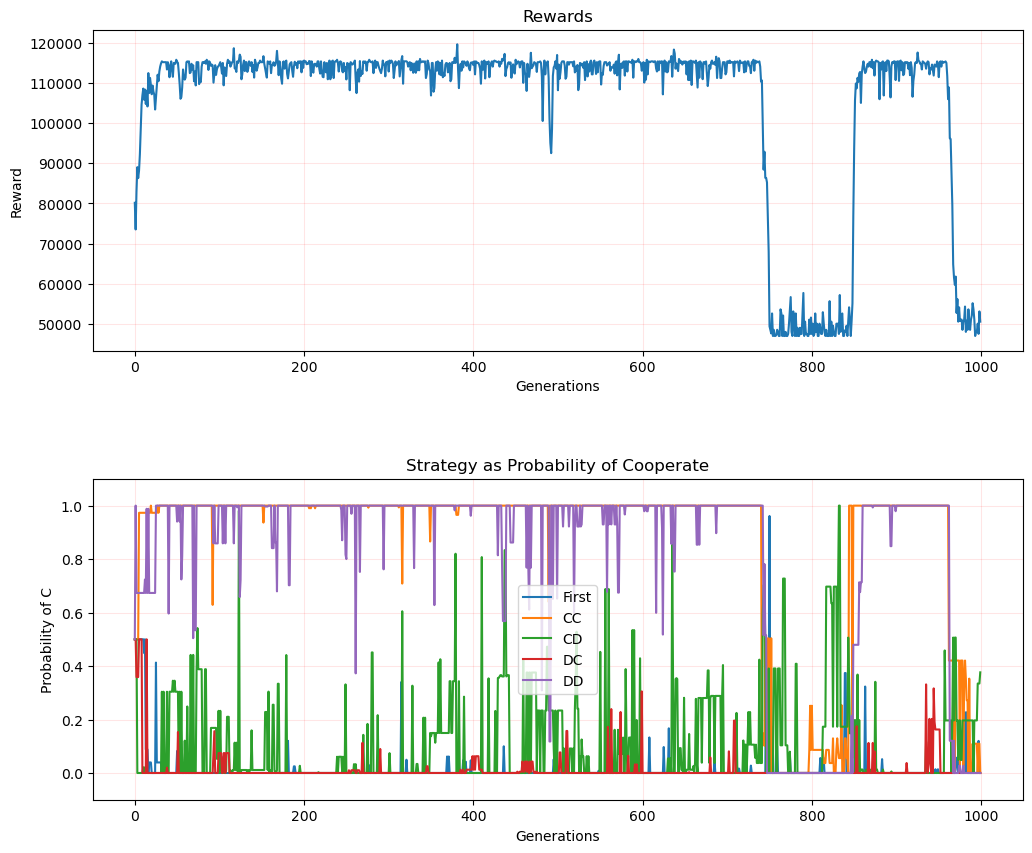


Best agent in last generation:

First move: 0.0 

      C       D
  -----------------
  |       |       | 
C |   0.0 | 0.376 | 
  |       |       | 
  -----------------
  |       |       | 
D |   0.0 |   0.0 | 
  |       |       | 
  -----------------

Reward: 50570.0


In [1104]:
run_experiment(environment=Environments[3] ,
               population_size=10,          
               num_children=5,              
               num_generations=1000,        
               crossover_prob=0.5,          
               mutate_std=0.4,              
               num_rounds=20,               
               play_each_other=True,
               print_pop=False,
               display_evol=True)

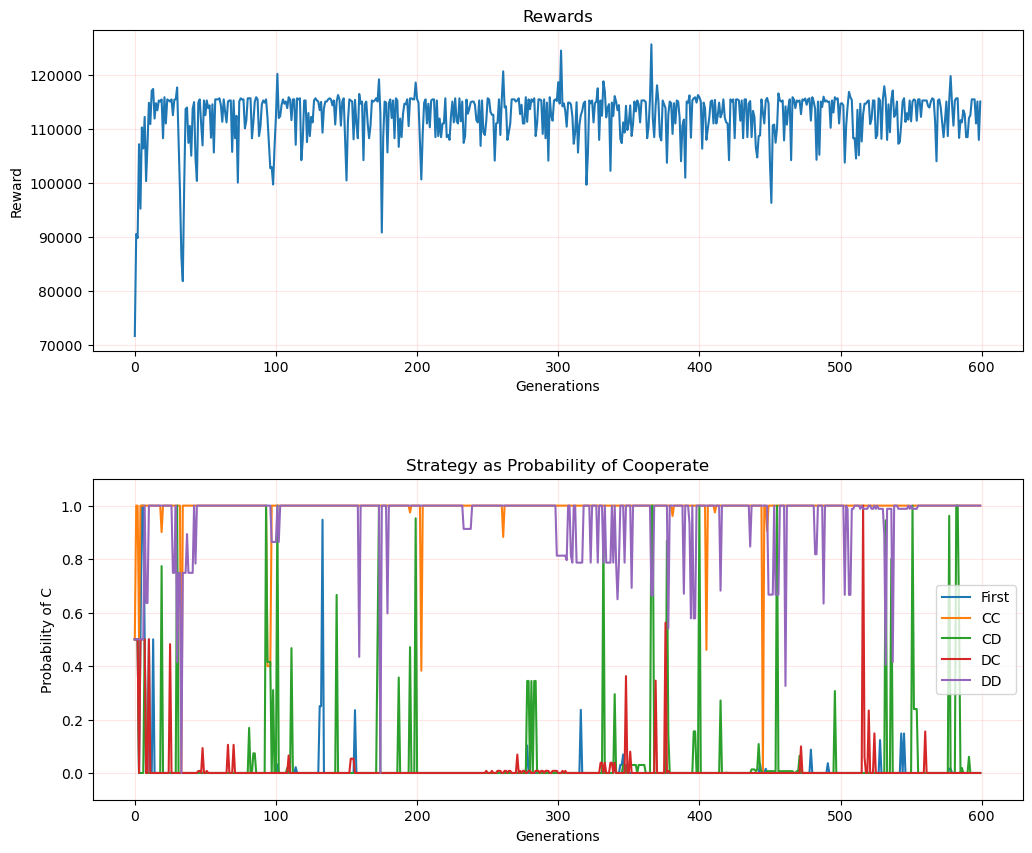


Best agent in last generation:

First move: 0 

      C       D
  -----------------
  |       |       | 
C |     1 |     0 | 
  |       |       | 
  -----------------
  |       |       | 
D |     0 |     1 | 
  |       |       | 
  -----------------

Reward: 115000


In [1112]:
run_experiment(environment=Environments[3] ,
               population_size=10,          
               num_children=5,              
               num_generations=600,         
               crossover_prob=0.9,          
               mutate_std=0.9,              
               num_rounds=20,               
               play_each_other=True,
               print_pop=False,
               display_evol=True)

With a lower learning rate, this population sometimes evolves into Pavlov, except that CD always varies. Adapting to Pavlov opponents just results in more Pavlovs, and that is also the optimal strategy for the population for some time. At some point though, the population becomes Devilish - I truly have no idea why this happens. Here, it seems like the turning point was CC suddenly dropping. If we keep it running for a few more thousand generations, we are likely to see a return to Pavlov tactics. This is really interesting, it seems like there is no stable equilibrium, and a few mutations set off a chain reaction that makes the population go between Devils and Pavlovs.

With a really high mutation / learning rate, we can see somewhat stable behavior with occasional extreme changes, but overall, again, Pavlov populations evolving.

# All TFTs

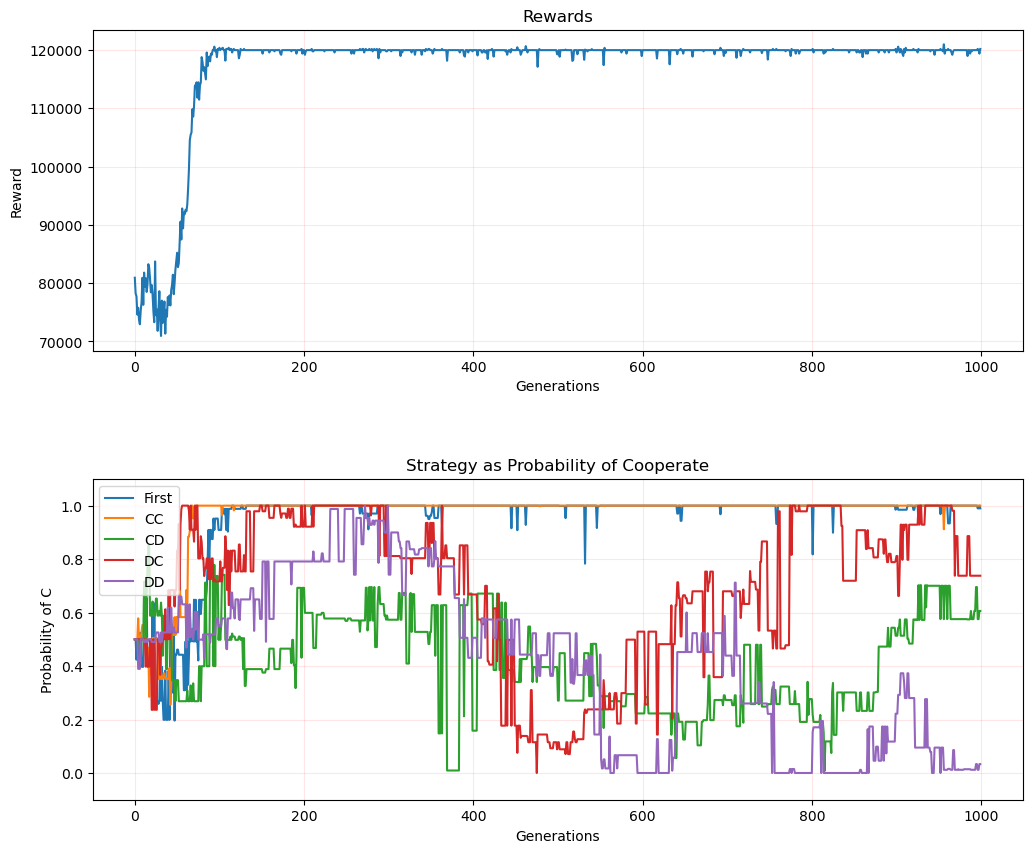


Best agent in last generation:

First move: 0.99 

      C       D
  -----------------
  |       |       | 
C |   1.0 | 0.606 | 
  |       |       | 
  -----------------
  |       |       | 
D | 0.738 | 0.033 | 
  |       |       | 
  -----------------

Reward: 120200.0


In [1105]:
run_experiment(environment=Environments[5] ,
               population_size=10,         
               num_children=5,             
               num_generations=1000,       
               crossover_prob=0.5,         
               mutate_std=0.1,             
               num_rounds=20,              
               play_each_other=True,
               print_pop=False,
               display_evol=True)

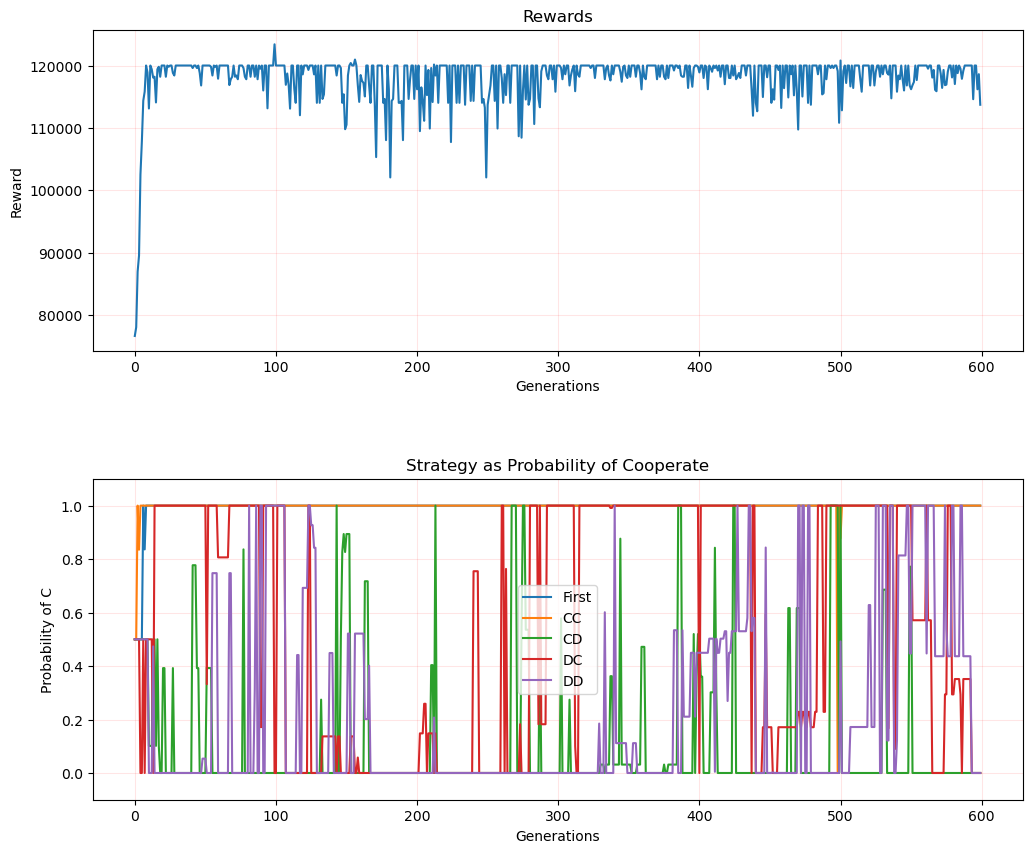


Best agent in last generation:

First move: 1 

      C       D
  -----------------
  |       |       | 
C |     1 |     0 | 
  |       |       | 
  -----------------
  |       |       | 
D |     0 |     0 | 
  |       |       | 
  -----------------

Reward: 113710


In [1113]:
run_experiment(environment=Environments[5] ,
               population_size=10,          
               num_children=5,              
               num_generations=600,         
               crossover_prob=0.9,          
               mutate_std=0.9,              
               num_rounds=20,               
               play_each_other=True,
               print_pop=False,
               display_evol=True)

The population evolves CC=1.0 and first move=~1 because that's the winning strategy against TFT. The overall strategy is similar to the one from the previous problem vs just TFTs.

Again, it doesn't seem like this population is intending on settling on some stable equilibrium, even after 1000 generations. Extreme mutation rates result in variable probabilities, but the end result we see here seems representative of where each probability spent most of its time.

# Mixed environment

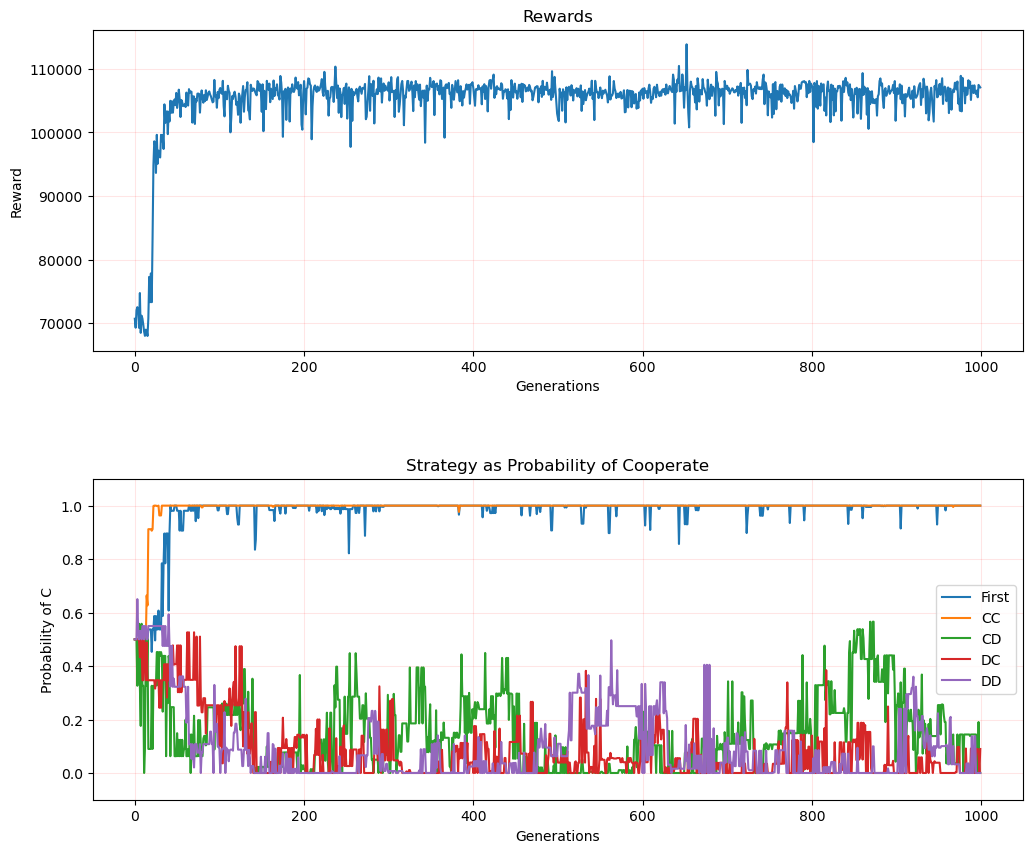


Best agent in last generation:

First move: 1.0 

      C       D
  -----------------
  |       |       | 
C |   1.0 |   0.0 | 
  |       |       | 
  -----------------
  |       |       | 
D |  0.09 |   0.0 | 
  |       |       | 
  -----------------

Reward: 107070.0


In [1106]:
run_experiment(environment=Environments[7] ,
               population_size=10,          
               num_children=5,              
               num_generations=1000,        
               crossover_prob=0.5,          
               mutate_std=0.1,              
               num_rounds=20,               
               play_each_other=True,
               print_pop=False,
               display_evol=True)

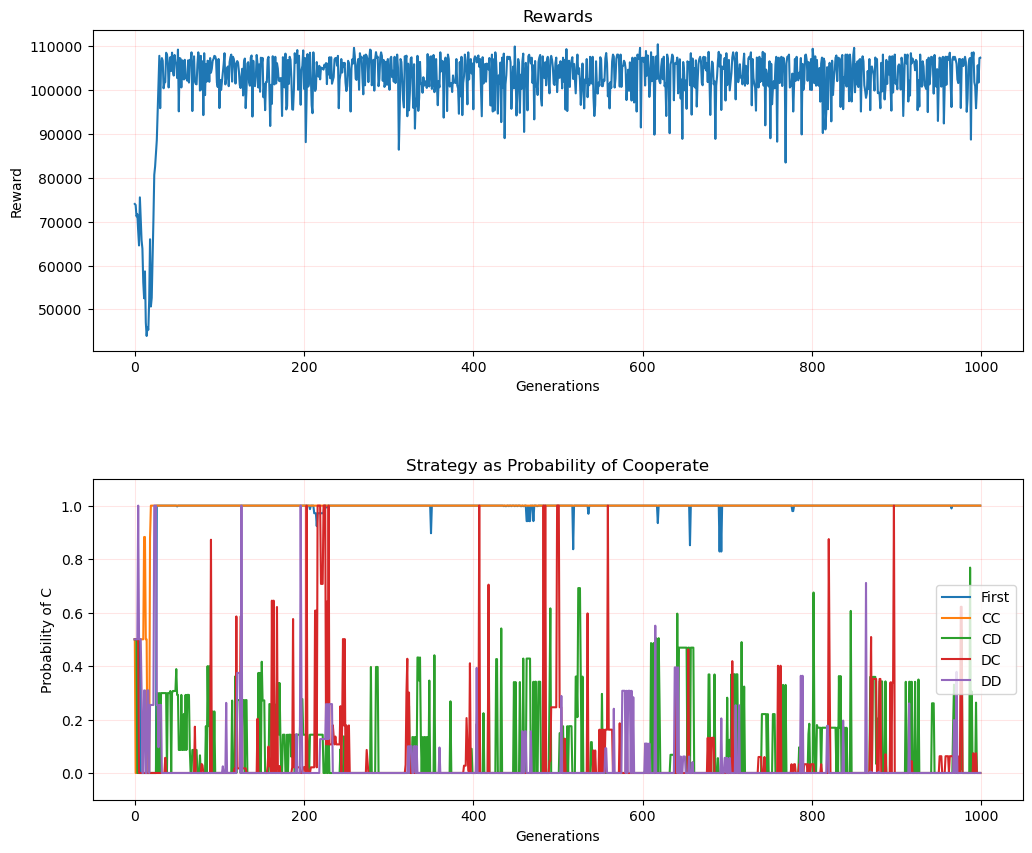


Best agent in last generation:

First move: 1 

      C       D
  -----------------
  |       |       | 
C |     1 |     0 | 
  |       |       | 
  -----------------
  |       |       | 
D |     0 |     0 | 
  |       |       | 
  -----------------

Reward: 107360


In [1114]:
run_experiment(environment=Environments[7] ,
               population_size=10,          
               num_children=5,              
               num_generations=1000,        
               crossover_prob=0.9,          
               mutate_std=0.9,              
               num_rounds=20,               
               play_each_other=True,
               print_pop=False,
               display_evol=True)

Again, cooperation loops are useful for the mixed environment, and as the population evolves for that, it becomes even more rewarding to cooperate. The initial nudge is from the environment, but the high cooperation between the population becomes very rewarding.